# Kickstarter
## 線形回帰
実際のデータを使って線形回帰を行う

In [47]:
# 必要なライブラリの読み込み
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import pydotplus
from mpl_toolkits.mplot3d import Axes3D
from heatmap import corrplot
from pylab import rcParams
import math

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

In [55]:
# データの読み込み
df = pd.read_csv("ks-projects-201801.csv")

In [56]:
print(df.shape)
print("Number of instances:", df.shape[0])
display(df.head(5))

(378661, 15)
Number of instances: 378661


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [57]:
# Get a quick overview of the dataset
display(df.describe())
display(df.info())

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


None

##### 予測時点で入手できるデータだけを残す
クラウドファンディングが終わるまで入手できない説明変数を含む予測に不適切なコラムをデータフレームから削除

In [58]:
df = df.drop(['ID', 'name', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real', 'usd_goal_real'], axis=1)
df.head(5)

,category,main_category,currency,deadline,goal,launched,state,country
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,canceled,US


"deadline"と"launched"からクラウドファンディングの日数を計算し、新しく変数として追加

In [59]:
df['launched'] = pd.to_datetime(df['launched']).dt.date
df['launched']= pd.to_datetime(df['launched'])
df['deadline']= pd.to_datetime(df['deadline'])
df['n_days_crowdfunding'] = df['deadline'] - df['launched']
df['n_days_crowdfunding'] = df['n_days_crowdfunding'].dt.days
#display(df.info())
df.head(5)

,category,main_category,currency,deadline,goal,launched,state,country,n_days_crowdfunding
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,failed,GB,59
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,failed,US,60
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,failed,US,45
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17,failed,US,30
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04,canceled,US,56


In [60]:
# この時点で""deadline"と"launched"は不要なので、データフレームから落とす
df = df.drop(['deadline', 'launched'], axis=1)
df.head(5)

,category,main_category,currency,goal,state,country,n_days_crowdfunding
0,Poetry,Publishing,GBP,1000.0,failed,GB,59
1,Narrative Film,Film & Video,USD,30000.0,failed,US,60
2,Narrative Film,Film & Video,USD,45000.0,failed,US,45
3,Music,Music,USD,5000.0,failed,US,30
4,Film & Video,Film & Video,USD,19500.0,canceled,US,56


### 欠損値の確認 / Checking for Missing Values

In [61]:
df.isna().sum()

category               0
main_category          0
currency               0
goal                   0
state                  0
country                0
n_days_crowdfunding    0
dtype: int64

Observation: There are no missing values in the dataframe to be used for analysis and building models

### データの可視化 / Data Visualization

#### Plot histogram for each variable where possible

##### State (Result of the crowdfuding)

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

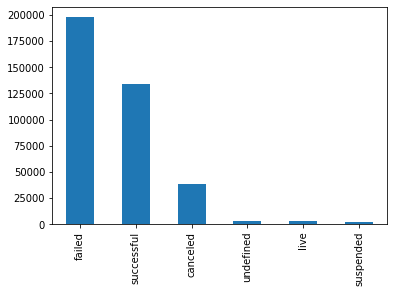

In [62]:
# State
display(df['state'].value_counts())
# Plot histogram
df['state'].value_counts().plot(kind='bar')

Since the significant number of projects are either in failed or successful, will only consider the two.

In [63]:
# Drop instances that neither "failed" or was "successful"
df = df[~df.state.str.contains("canceled")]
df = df[~df.state.str.contains("undefined")]
df = df[~df.state.str.contains("live")]
df = df[~df.state.str.contains("suspended")]
print(df['state'].value_counts())
display(df.shape)
df.head(5)

failed        197719
successful    133956
Name: state, dtype: int64


(331675, 7)

,category,main_category,currency,goal,state,country,n_days_crowdfunding
0,Poetry,Publishing,GBP,1000.0,failed,GB,59
1,Narrative Film,Film & Video,USD,30000.0,failed,US,60
2,Narrative Film,Film & Video,USD,45000.0,failed,US,45
3,Music,Music,USD,5000.0,failed,US,30
5,Restaurants,Food,USD,50000.0,successful,US,35


Now, the problem has become a binary classification task.

##### Category
Note that the xlabels in the histogram is too small, but will consider it ignorable. If one wanted to know the ordering, it can be determined from value_counts and ordering where needed.

Product Design       18680
Documentary          14523
Music                12633
Tabletop Games       11744
Shorts               11394
Food                 10416
Video Games           9328
Film & Video          8624
Fiction               8108
Fashion               7529
Art                   7486
Nonfiction            7414
Theater               6684
Rock                  6246
Children's Books      6198
Apparel               6166
Technology            5726
Indie Rock            5329
Apps                  5287
Photography           5246
Webseries             5148
Publishing            5052
Narrative Film        4618
Comics                4581
Web                   4309
Country & Folk        4213
Crafts                4152
Design                3547
Hip-Hop               3459
Hardware              3115
                     ...  
Blues                  234
Animals                229
Couture                227
Fabrication Tools      215
Makerspaces            208
Movie Theaters         201
P

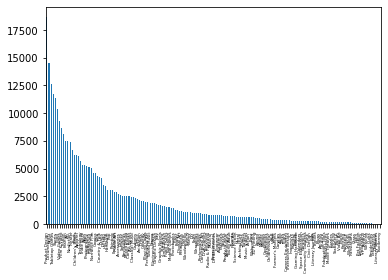

In [64]:
display(df['category'].value_counts())
plt.xticks(fontsize=4)
df['category'].value_counts().plot(kind='bar')

##### Main Category

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

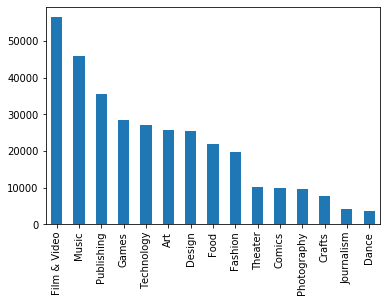

In [65]:
# Main category
display(df['main_category'].value_counts())
df['main_category'].value_counts().plot(kind='bar')

##### Currency

USD    261511
GBP     29476
EUR     14378
CAD     12375
AUD      6621
SEK      1510
MXN      1411
NZD      1274
DKK       929
CHF       652
NOK       584
HKD       477
SGD       454
JPY        23
Name: currency, dtype: int64

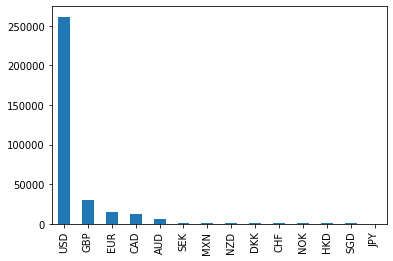

In [66]:
display(df['currency'].value_counts())
df['currency'].value_counts().plot(kind='bar')

In [67]:
261511 / df.shape[0]

0.7884555664430541

Observation: 78.8% of the data is done in USD.

In [68]:
(261511 + 29476 + 14378 + 12375 + 6621) / df.shape[0]

0.9779482927564634

Observation: Over 97% of the data is in USD, GBP, EUR, CAD, or AUD. 
- Delete everything else.

In [69]:
# Drop instances that except for the top 5 currencies
display(df.shape)
to_drop = ['SEK', 'MXN', 'NZD', 'DKK', 'CHF', 'NOK', 'HKD', 'SGD', 'JPY']
df = df[~df['currency'].isin(to_drop)]
display(df.shape)
df.head(5)

(331675, 7)

(324361, 7)

,category,main_category,currency,goal,state,country,n_days_crowdfunding
0,Poetry,Publishing,GBP,1000.0,failed,GB,59
1,Narrative Film,Film & Video,USD,30000.0,failed,US,60
2,Narrative Film,Film & Video,USD,45000.0,failed,US,45
3,Music,Music,USD,5000.0,failed,US,30
5,Restaurants,Food,USD,50000.0,successful,US,35


##### Goal

count    3.243610e+05
mean     4.039433e+04
std      1.061090e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.000000e+03
75%      1.500000e+04
max      1.000000e+08
Name: goal, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000254D94B96D8>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000254D9560128>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000254D95ADAC8>]],
      dtype=object)

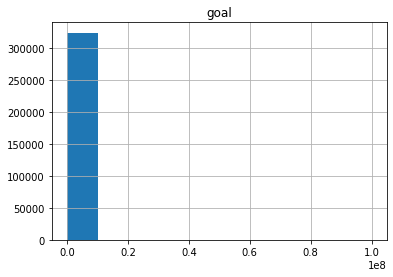

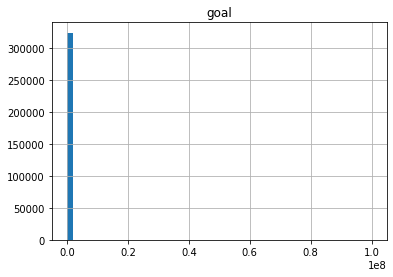

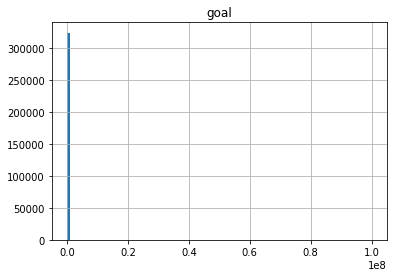

In [70]:
display(df['goal'].describe())
display(df.hist(column='goal'))
display(df.hist(column='goal', bins=50))
df.hist(column='goal', bins=100)

#### Country

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
IE         683
BE         523
AT         485
N,0"       204
LU          57
Name: country, dtype: int64

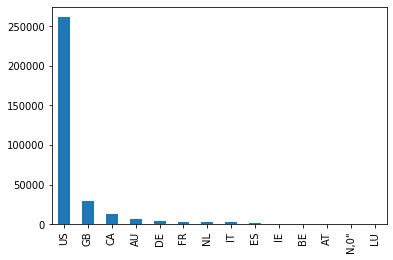

In [71]:
display(df['country'].value_counts())
df['country'].value_counts().plot(kind='bar')

##### Number of days given for the crowdfunding project

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000254DA11FF98>]],
      dtype=object)

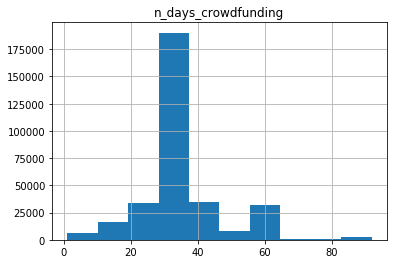

In [72]:
display(df.hist(column='n_days_crowdfunding'))

### Plot a variable against crowdfunding result
Category, main category, currency, country

#### Category vs State(Result)
Will not do because there are too many categories

#### Main Category vs State(Result)

main_category,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater,All
state,,,,,,,,,,,,,,,,
failed,13804,3986,5534,1208,14295,13803,32387,15622,15523,3037,21345,6265,22678,19743,3641,192871
successful,11314,5779,2068,2318,10113,5436,23293,5997,12219,978,23963,3263,12076,6207,6466,131490
All,25118,9765,7602,3526,24408,19239,55680,21619,27742,4015,45308,9528,34754,25950,10107,324361


[Text(0, 0, 'Publishing'),
 Text(0, 0, 'Film & Video'),
 Text(0, 0, 'Music'),
 Text(0, 0, 'Food'),
 Text(0, 0, 'Crafts'),
 Text(0, 0, 'Games'),
 Text(0, 0, 'Design'),
 Text(0, 0, 'Comics'),
 Text(0, 0, 'Fashion'),
 Text(0, 0, 'Theater'),
 Text(0, 0, 'Art'),
 Text(0, 0, 'Photography'),
 Text(0, 0, 'Technology'),
 Text(0, 0, 'Dance'),
 Text(0, 0, 'Journalism')]

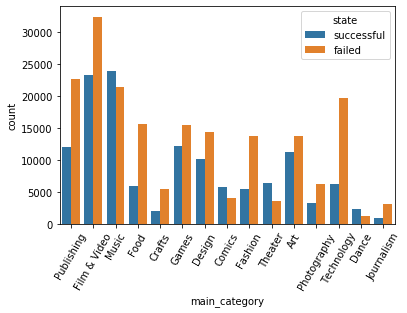

In [73]:
# Main category
df_h = pd.crosstab(index=df["state"], columns=df["main_category"], margins=True)
display(df_h)
h = sns.countplot(x="main_category", hue="state", hue_order=["successful", "failed"], data=df)
h.set_xticklabels(h.get_xticklabels(), rotation=60)

Observations
- Publishing, Food, Crafts, Fshion, Art, Photography, Technology, and Journalism have at least double the fail rate than success rate.

#### Currency vs State(Result)

currency,AUD,CAD,EUR,GBP,USD,All
state,,,,,,
failed,4610,8238,10496,17395,152132,192871
successful,2011,4137,3882,12081,109379,131490
All,6621,12375,14378,29476,261511,324361


[Text(0, 0, 'GBP'),
 Text(0, 0, 'USD'),
 Text(0, 0, 'CAD'),
 Text(0, 0, 'AUD'),
 Text(0, 0, 'EUR')]

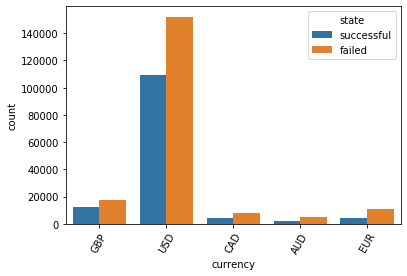

In [74]:
df_c = pd.crosstab(index=df["state"], columns=df["currency"], margins=True)
display(df_c)
c = sns.countplot(x="currency", hue="state", hue_order=["successful", "failed"], data=df)
c.set_xticklabels(c.get_xticklabels(), rotation=60)

Observations
- Fundraising done in Euro seems to have an exceptionally high failure rate compared to other currency
- There are fluctuations in the rate of success depending on the currency

count    324361.000000
mean         33.958232
std          12.732551
min           1.000000
25%          30.000000
50%          30.000000
75%          36.000000
max          92.000000
Name: n_days_crowdfunding, dtype: float64

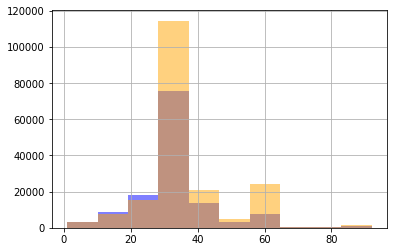

In [75]:
success = df[df["state"] == "successful"]
fail = df[df["state"] == "failed"]

success["n_days_crowdfunding"].hist(color="blue", alpha=.5)
fail["n_days_crowdfunding"].hist(color="orange", alpha=.5)

#plt.hist(df['n_days_crowdfunding'])
df['n_days_crowdfunding'].describe()

Observations
- Most crowdfunding events is in the range 30-40
- Distribution of number of days of the crowdfunding seems somewhat similar between the succeeded and failed projects, though not entirely the same.
- Surprisingly, it even seems that successful project have shorter number of days for the fundraising.

#### Look at correlation
Create a heatmap

In [76]:
df['main_category'] =df['main_category'].astype('category').cat.codes
df['currency'] =df['currency'].astype('category').cat.codes
df['state'] =df['state'].astype('category').cat.codes
df['country'] =df['country'].astype('category').cat.codes
df.head(5)

,category,main_category,currency,goal,state,country,n_days_crowdfunding
0,Poetry,12,3,1000.0,0,7,59
1,Narrative Film,6,4,30000.0,0,13,60
2,Narrative Film,6,4,45000.0,0,13,45
3,Music,10,4,5000.0,0,13,30
5,Restaurants,7,4,50000.0,1,13,35


In [77]:
#Reorganize the columns order for a later step
col_name = "state"
first_col = df.pop(col_name)
df.insert(0, col_name, first_col)
df.head(5)

,state,category,main_category,currency,goal,country,n_days_crowdfunding
0,0,Poetry,12,3,1000.0,7,59
1,0,Narrative Film,6,4,30000.0,13,60
2,0,Narrative Film,6,4,45000.0,13,45
3,0,Music,10,4,5000.0,13,30
5,1,Restaurants,7,4,50000.0,13,35


Correlation Matrix


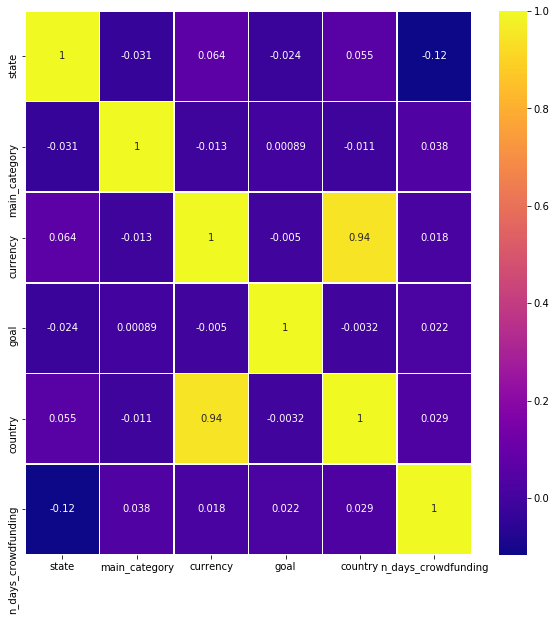

In [78]:
print("Correlation Matrix")
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cmap='plasma', linewidths=0.5)

Observation:
- Currency and country are highly correlated which is not surprising. => Will remove one of them: country
- When checked against state, n_days_crowdfunding has the strongest value with -0.12
- In short, there seems to be no one variable that is clearly related to state i.e. the crowdfunding result

In [79]:
# Delete country
df = df.drop(['country'], axis=1)
df.head(5)

,state,category,main_category,currency,goal,n_days_crowdfunding
0,0,Poetry,12,3,1000.0,59
1,0,Narrative Film,6,4,30000.0,60
2,0,Narrative Film,6,4,45000.0,45
3,0,Music,10,4,5000.0,30
5,1,Restaurants,7,4,50000.0,35


Correlation Matrix


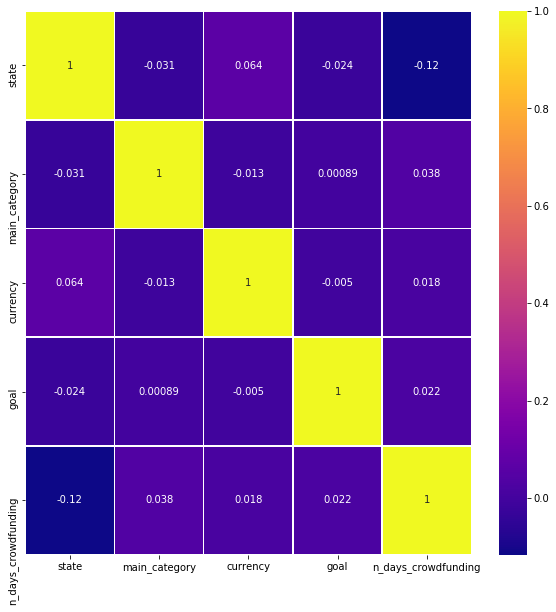

In [80]:
# Recreate a heatmap without country
print("Correlation Matrix")
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cmap='plasma', linewidths=0.5)

In [81]:
X = df[['main_category','currency', 'goal', 'n_days_crowdfunding']]
X.head(5)

,main_category,currency,goal,n_days_crowdfunding
0,12,3,1000.0,59
1,6,4,30000.0,60
2,6,4,45000.0,45
3,10,4,5000.0,30
5,7,4,50000.0,35


In [82]:
df.state = pd.Categorical(df.state)
y = df.state.cat.codes
display(y.shape)
y.head(5)
#print(y.value_counts())

(324361,)

0    0
1    0
2    0
3    0
5    1
dtype: int8

In [83]:
# Create a logistic regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

model = LogisticRegression(solver='liblinear', multi_class='auto')
model.fit(X_train_std, y_train)

# Use the model to make predictions
y_pred = model.predict(X_test_std)

count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

(259488, 4)
(64873, 4)
(259488,)
(64873,)
Misclassified samples: 25356
Accuracy: 0.61


confusion matrix = 
 [[35933  2645]
 [22711  3584]]
accuracy =  0.6091440198541767
precision =  0.5940521546571502
recall =  0.5338686418354278
f1 score =  0.4797929641257526


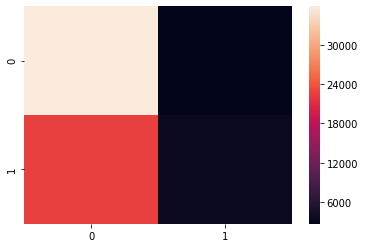

In [84]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('confusion matrix = \n', cm)
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred, average='macro'))
sns.heatmap(cm)

##### Reducing the number of instances
The number of instances is massive (30K~), which can lead to a long running time. Therefore, will take 10% of the data used above and see if a model with similar accuracy can be produced.

In [85]:
df_merged = pd.concat([X, y], axis=1)
df_merged = df_merged.rename(columns = {0:'state'})

df_10 = df_merged.sample(frac=0.1)
display(df_10.shape)
display(df_10.head(5))
df_10.reset_index(drop=True, inplace=True)
display(df_10.head(5))
X_10 = df_10[['main_category','currency', 'goal', 'n_days_crowdfunding']]
y_10 = df_10['state']

display(X_10.head(5))
display(y_10.head(5))

(32436, 5)

,main_category,currency,goal,n_days_crowdfunding,state
173742,6,4,35000.0,30,0
140090,8,4,100000.0,30,0
186988,6,4,1500.0,29,1
142393,12,4,2000.0,30,0
26386,1,4,500.0,30,1


,main_category,currency,goal,n_days_crowdfunding,state
0,6,4,35000.0,30,0
1,8,4,100000.0,30,0
2,6,4,1500.0,29,1
3,12,4,2000.0,30,0
4,1,4,500.0,30,1


,main_category,currency,goal,n_days_crowdfunding
0,6,4,35000.0,30
1,8,4,100000.0,30
2,6,4,1500.0,29
3,12,4,2000.0,30
4,1,4,500.0,30


0    0
1    0
2    1
3    0
4    1
Name: state, dtype: int8

(25948, 4)
(6488, 4)
(25948,)
(6488,)
Misclassified samples: 2607
Accuracy: 0.60
confusion matrix = 
 [[3592  265]
 [2342  289]]
accuracy =  0.5981812577065352
precision =  0.5634929470870307
recall =  0.520568958668444
f1 score =  0.45760536500137006


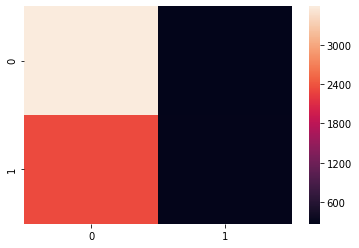

In [86]:
# Run the code again with 10% of data
X_train, X_test, y_train, y_test = train_test_split(X_10, y_10, test_size=0.2, random_state=101)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

model = LogisticRegression(solver='liblinear', multi_class='auto')
model.fit(X_train_std, y_train)

# Use the model to make predictions
y_pred = model.predict(X_test_std)

count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('confusion matrix = \n', cm)
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred, average='macro'))
sns.heatmap(cm)

Result: (One of the runs)
- Accuracy: 0.609 -> 0.616
- Precision: 0.594 -> 0.605
- Recall: 0.534 -> 0.532

##### Remark:
Accuracy, precision, and recall are almost the same. Therefore, to save running time, will use 10% of the data from here on.

### Cross Validation
- Use cross validation.
- Repeat the same thing as for Logistic Regression above but using cross validation

   main_category  currency      goal  n_days_crowdfunding
1              8         4  100000.0                   30
2              6         4    1500.0                   29
4              1         4     500.0                   30
5              4         4    7000.0                   36
6             10         2    3500.0                   30
confusion matrix = 
 [[3831    0]
 [2656    1]]
accuracy =  0.5906288532675709
precision =  0.7952828734391861
recall =  0.5001881821603312


   main_category  currency      goal  n_days_crowdfunding
0              6         4   35000.0                   30
1              8         4  100000.0                   30
2              6         4    1500.0                   29
3             12         4    2000.0                   30
4              1         4     500.0                   30
confusion matrix = 
 [[3831    0]
 [2656    0]]
accuracy =  0.5905657468783722
precision =  0.2952828734391861
recall =  0.5


   main_category  currency      goa

C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


confusion matrix = 
 [[3884    0]
 [2603    0]]
accuracy =  0.5987359334052721
precision =  0.29936796670263605
recall =  0.5


   main_category  currency     goal  n_days_crowdfunding
0              6         4  35000.0                   30
2              6         4   1500.0                   29
3             12         4   2000.0                   30
4              1         4    500.0                   30
5              4         4   7000.0                   36
confusion matrix = 
 [[3881    0]
 [2606    0]]
accuracy =  0.598273470016957
precision =  0.2991367350084785
recall =  0.5


   main_category  currency      goal  n_days_crowdfunding
0              6         4   35000.0                   30
1              8         4  100000.0                   30
2              6         4    1500.0                   29
3             12         4    2000.0                   30
4              1         4     500.0                   30


C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


confusion matrix = 
 [[3858    0]
 [2629    0]]
accuracy =  0.594727917373208
precision =  0.297363958686604
recall =  0.5


Average accuracy: 0.5945863841882759
Average precision: 0.3972868814552182
Average recall: 0.5000376364320662
[[3.857e+03 0.000e+00]
 [2.630e+03 2.000e-01]]


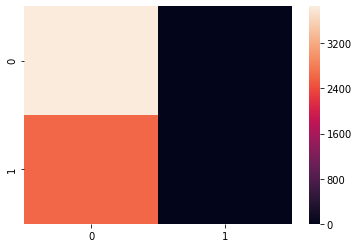

In [87]:
# Logistic regression with cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

n = 5
kf = KFold(n_splits=n, random_state=None, shuffle=True)

results = []

cm_all = np.zeros((2, 2))
acc_total = 0
prec_total = 0
recall_total = 0

for train_idx, test_idx in kf.split(X_10):
    X_train = X_10.iloc[train_idx]
    X_test = X_10.iloc[test_idx]
    y_train = y_10[train_idx]
    y_test = y_10[test_idx]
    
    print(X_train.head(5))

    # Define and fit the model
    model = LogisticRegression(solver='liblinear', multi_class='auto')
    model.fit(X_train, y_train)

    # Use the model to make predictions
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    acc_total += accuracy_score(y_true=y_test, y_pred=y_pred)
    prec_total += precision_score(y_true=y_test, y_pred=y_pred, average='macro')
    recall_total += recall_score(y_true=y_test, y_pred=y_pred, average='macro')
    cm_all += cm
    
    print('confusion matrix = \n', cm)
    print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
    print('precision = ', precision_score(y_true=y_test, y_pred=y_pred, average='macro'))
    print('recall = ', recall_score(y_true=y_test, y_pred=y_pred, average='macro'))
    print("\n")
    #print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred, average='macro'))

    
print("Average accuracy:", acc_total / n)
print("Average precision:", prec_total / n)
print("Average recall:", recall_total / n)
print(cm_all/n)
sns.heatmap(cm_all/n)

#### Outliers

In [36]:
df_merged = pd.concat([X_10, y_10], axis=1)
df_merged = df_merged.rename(columns = {0:'state'})

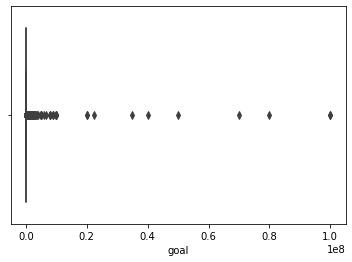

In [37]:
# Boxplot prior to removing outliers from 'goal'
sns.boxplot(x=df_merged['goal'])

In [38]:
# Remove outliers for goal
low = 0.05
high = 0.95
quant_df_merged = df_merged['goal'].quantile([low, high])
quant_df_merged.head(5)

0.05      350.0
0.95    70000.0
Name: goal, dtype: float64

In [39]:
display(df_merged.shape)
df_merged = df_merged[(df_merged['goal'] > 350.0) & (df_merged['goal'] < 75000)]
display(df_merged.shape)
df_merged.head(5)

(32436, 5)

(29229, 5)

,main_category,currency,goal,n_days_crowdfunding,state
0,7,4,5000.0,17,0
1,12,4,6000.0,30,0
2,6,4,8750.0,43,0
3,10,4,5000.0,24,1
4,13,3,28000.0,28,0


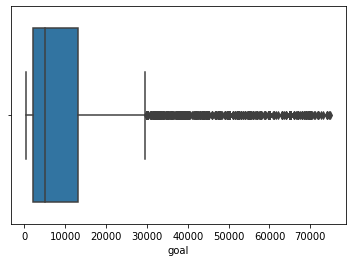

In [40]:
# Boxplot after  to removing outliers from 'goal'
sns.boxplot(x=df_merged['goal'])

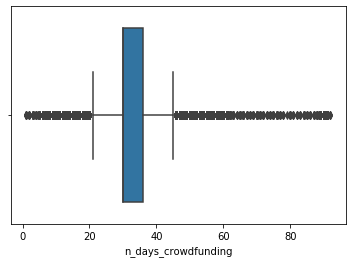

In [41]:
# Boxplot prior to removing outliers from 'goal'
sns.boxplot(x=df_merged['n_days_crowdfunding'])

In [42]:
# Remove outliers for n_days_crowdfunding
low = 0.05
high = 0.95
quant_df_merged = df_merged['n_days_crowdfunding'].quantile([low, high])
quant_df_merged.head(5)

0.05    17.0
0.95    60.0
Name: n_days_crowdfunding, dtype: float64

In [43]:
display(df_merged.shape)
df_merged = df_merged[(df_merged['n_days_crowdfunding'] > 16.0) & (df_merged['n_days_crowdfunding'] < 60.0)]
display(df_merged.shape)
df_merged.head(5)

(29229, 5)

(24968, 5)

,main_category,currency,goal,n_days_crowdfunding,state
0,7,4,5000.0,17,0
1,12,4,6000.0,30,0
2,6,4,8750.0,43,0
3,10,4,5000.0,24,1
4,13,3,28000.0,28,0


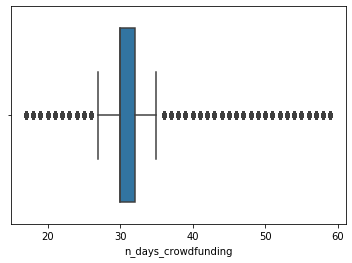

In [44]:
# Boxplot prior to removing outliers from 'goal'
sns.boxplot(x=df_merged['n_days_crowdfunding'])

In [45]:
df_merged.reset_index(drop=True, inplace=True)
X_10 = df_merged[['main_category','currency', 'goal', 'n_days_crowdfunding']]
y_10 = df_merged['state']

display(X_10.head(5))
display(y_10.head(5))

,main_category,currency,goal,n_days_crowdfunding
0,7,4,5000.0,17
1,12,4,6000.0,30
2,6,4,8750.0,43
3,10,4,5000.0,24
4,13,3,28000.0,28


0    0
1    0
2    0
3    1
4    0
Name: state, dtype: int8

Now, rerun the logistic regression with the data with outliers removed.

C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


confusion matrix = 
 [[2866    0]
 [2128    0]]
accuracy =  0.5738886663996796
precision =  0.2869443331998398
recall =  0.5


confusion matrix = 
 [[2540  320]
 [1719  415]]
accuracy =  0.591710052062475
precision =  0.5805049890348251
recall =  0.5412911830437603




C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


confusion matrix = 
 [[2838    0]
 [2156    0]]
accuracy =  0.5682819383259912
precision =  0.2841409691629956
recall =  0.5


confusion matrix = 
 [[2854    0]
 [2139    0]]
accuracy =  0.571600240336471
precision =  0.2858001201682355
recall =  0.5


confusion matrix = 
 [[2885    0]
 [2108    0]]
accuracy =  0.5778089325055077
precision =  0.28890446625275384
recall =  0.5


Average accuracy: 0.5766579659260248
Average precision: 0.3452589755637299
Average recall: 0.508258236608752
[[2796.6   64. ]
 [2050.    83. ]]


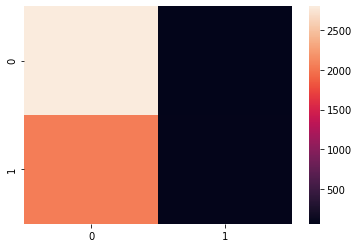

In [46]:
# Logistic regression with cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

n = 5
kf = KFold(n_splits=n, random_state=None, shuffle=True)

results = []

cm_all = np.zeros((2, 2))
acc_total = 0
prec_total = 0
recall_total = 0

for train_idx, test_idx in kf.split(X_10):
    X_train = X_10.iloc[train_idx]
    X_test = X_10.iloc[test_idx]
    y_train = y_10[train_idx]
    y_test = y_10[test_idx]
    
    #print(X_train.head(5))

    # Define and fit the model
    model = LogisticRegression(solver='liblinear', multi_class='auto')
    model.fit(X_train, y_train)

    # Use the model to make predictions
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    acc_total += accuracy_score(y_true=y_test, y_pred=y_pred)
    prec_total += precision_score(y_true=y_test, y_pred=y_pred, average='macro')
    recall_total += recall_score(y_true=y_test, y_pred=y_pred, average='macro')
    cm_all += cm
    
    print('confusion matrix = \n', cm)
    print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
    print('precision = ', precision_score(y_true=y_test, y_pred=y_pred, average='macro'))
    print('recall = ', recall_score(y_true=y_test, y_pred=y_pred, average='macro'))
    print("\n")
    #print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred, average='macro'))
    
print("Average accuracy:", acc_total / n)
print("Average precision:", prec_total / n)
print("Average recall:", recall_total / n)
print(cm_all/n)
sns.heatmap(cm_all/n)

Observation:
- The model accuracy actually dropped...
- It can be due to the outliers (e.g. ones having extremely high goal) tending to fail

=> Will bring back the dataset without cutting the outliers

### SVM

In [89]:
display(X_10.shape)
y_10.shape

(32436, 4)

(32436,)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_10, y_10, test_size=0.2, random_state=None)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(25948, 4)
(6488, 4)
(25948,)
(6488,)


In [91]:
# Standarization
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

model = SVC(kernel='linear', random_state=None)
model.fit(X_train_std, y_train)
# Use the model to make predictions
y_pred = model.predict(X_test_std)

count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 2618
Accuracy: 0.60


C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


confusion matrix = 
 [[3855    0]
 [2633    0]]
accuracy =  0.594173859432799
precision =  0.2970869297163995
recall =  0.5




C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


confusion matrix = 
 [[3840    0]
 [2647    0]]
accuracy =  0.5919531370433174
precision =  0.2959765685216587
recall =  0.5




C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


confusion matrix = 
 [[3888    0]
 [2599    0]]
accuracy =  0.5993525512563589
precision =  0.29967627562817944
recall =  0.5




C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


confusion matrix = 
 [[3841    0]
 [2646    0]]
accuracy =  0.5921072915060891
precision =  0.29605364575304455
recall =  0.5


confusion matrix = 
 [[3861    0]
 [2626    0]]
accuracy =  0.5951903807615231
precision =  0.29759519038076154
recall =  0.5


Average accuracy: 0.5945554440000175
Average precision: 0.29727772200000874
Average recall: 0.5
[[3857.     0. ]
 [2630.2    0. ]]


C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


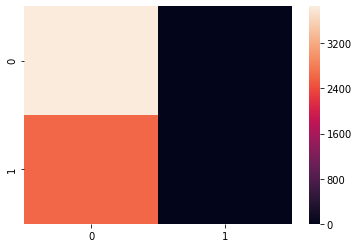

In [93]:
# SVM with cross validation
n = 5
kf = KFold(n_splits=n, random_state=None, shuffle=True)

results = []

cm_all = np.zeros((2, 2))
acc_total = 0
prec_total = 0
recall_total = 0

for train_idx, test_idx in kf.split(X_10):
    X_train = X_10.iloc[train_idx]
    X_test = X_10.iloc[test_idx]
    y_train = y_10[train_idx]
    y_test = y_10[test_idx]

    # Standarization
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)

    model = SVC(kernel='linear', random_state=None)
    model.fit(X_train_std, y_train)
    # Use the model to make predictions
    y_pred = model.predict(X_test_std)
    
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    acc_total += accuracy_score(y_true=y_test, y_pred=y_pred)
    prec_total += precision_score(y_true=y_test, y_pred=y_pred, average='macro')
    recall_total += recall_score(y_true=y_test, y_pred=y_pred, average='macro')
    cm_all += cm
    
    print('confusion matrix = \n', cm)
    print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
    print('precision = ', precision_score(y_true=y_test, y_pred=y_pred, average='macro'))
    print('recall = ', recall_score(y_true=y_test, y_pred=y_pred, average='macro'))
    print("\n")
    #print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred, average='macro'))
    
print("Average accuracy:", acc_total / n)
print("Average precision:", prec_total / n)
print("Average recall:", recall_total / n)
print(cm_all/n)
sns.heatmap(cm_all/n)

Observation:
- The accuracy is pretty much the same as that of logistic regression

### Hyperparameter Tuning

In [94]:
# Tune for C value and penalty
# C value: regularization strength
# penality: L1 or L2 regularization

logistic = LogisticRegression(solver='liblinear')
penalty = ['l1', 'l2']  # L1 and L2 regularizations

C = np.logspace(0,4,10)

hyperparameters = dict(C=C, penalty=penalty)

# Find the model using grid search
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_10, y_10)

print("Best penalty:", best_model.best_estimator_.get_params()['penalty'])
print("Best C:", best_model.best_estimator_.get_params()['C'])

Best penalty: l1
Best C: 1291.5496650148827


In [95]:
kfold = KFold(n_splits=5, random_state=None)
model = LogisticRegression(solver='liblinear', C=1291.5496650148827, penalty='l1')
results = cross_val_score(model, X_10, y_10, cv=kfold)
print("Accuracy:", results.mean())

Accuracy: 0.6103400816619485


Result: The model accuracy improved slightly!

### Attempts to improve model accuracy

1. Try with 'n_days_crowdfunding' only as a predictor

In [97]:
X_10_ndays = X_10[['n_days_crowdfunding']]
display(X_10_ndays.shape)
X_10_ndays.head(5)

(32436, 1)

,n_days_crowdfunding
0,30
1,30
2,29
3,30
4,30


C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


confusion matrix = 
 [[3802    0]
 [2686    0]]
accuracy =  0.5860049321824907
precision =  0.29300246609124536
recall =  0.5


confusion matrix = 
 [[3865    0]
 [2622    0]]
accuracy =  0.5958069986126099
precision =  0.29790349930630494
recall =  0.5


confusion matrix = 
 [[3823    1]
 [2663    0]]
accuracy =  0.5893325111761986
precision =  0.29471168670983655
recall =  0.4998692468619247


confusion matrix = 
 [[3880    0]
 [2607    0]]
accuracy =  0.5981193155541853
precision =  0.29905965777709265
recall =  0.5




C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yumika\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


confusion matrix = 
 [[3914    0]
 [2573    0]]
accuracy =  0.603360567288423
precision =  0.3016802836442115
recall =  0.5


Average accuracy: 0.5945248649627815
Average precision: 0.2972715187057382
Average recall: 0.4999738493723849
[[3.8568e+03 2.0000e-01]
 [2.6302e+03 0.0000e+00]]


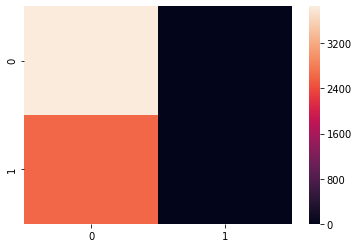

In [98]:
# Logistic regression with cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

n = 5
kf = KFold(n_splits=n, random_state=None, shuffle=True)

results = []

cm_all = np.zeros((2, 2))
acc_total = 0
prec_total = 0
recall_total = 0

for train_idx, test_idx in kf.split(X_10_ndays):
    X_train = X_10.iloc[train_idx]
    X_test = X_10.iloc[test_idx]
    y_train = y_10[train_idx]
    y_test = y_10[test_idx]
    
    #print(X_train.head(5))

    # Define and fit the model
    model = LogisticRegression(solver='liblinear', multi_class='auto')
    model.fit(X_train, y_train)

    # Use the model to make predictions
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    acc_total += accuracy_score(y_true=y_test, y_pred=y_pred)
    prec_total += precision_score(y_true=y_test, y_pred=y_pred, average='macro')
    recall_total += recall_score(y_true=y_test, y_pred=y_pred, average='macro')
    cm_all += cm
    
    print('confusion matrix = \n', cm)
    print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
    print('precision = ', precision_score(y_true=y_test, y_pred=y_pred, average='macro'))
    print('recall = ', recall_score(y_true=y_test, y_pred=y_pred, average='macro'))
    print("\n")
    #print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred, average='macro'))
    
print("Average accuracy:", acc_total / n)
print("Average precision:", prec_total / n)
print("Average recall:", recall_total / n)
print(cm_all/n)
sns.heatmap(cm_all/n)

Observation:
- Not much improvement. Lower accuracy than the GridSearch one.

### Note
The code cannot be reported, but when the combination: n_days_crowdfunding", "main_category_Music", "main_category_Technology", "main_category_Theater" was used (main_category_Music, main_category_Technology, and main_category_Theater resulting from conversion of main_category into dummy variables), an accuracy of 0.62 were yielded. The results of other experiments (combinations) are noted below.
- 0.61: goal, currency, n_days
- 0.61: goal, n_days
- 0.59: goal, currency
- 0.59: goal
- 0.60: n_days
- 0.62: n_days_crowdfunding", "main_category_Music", "main_category_Technology", "main_category_Theater


#### Conclusion: Further dividing up each variable e.g. "main_category_Music", "main_category_Technology", "main_category_Theater" instead of main_category may help improve the accuracy.

Note (Missing value for the overall dataframe prior to deleting some columns)
- Only "name" and "usd pledged" has missing values
- Will not bother calculating the percentage for name, since 4 / 37K is obviously small
- Since there are 37K (37,000~) instances, will drop these 4 and 3797 instances (=rows) from the dataframe if those columns are still in the dataframe